# Build NN

## 1. Prepare datasets

In [18]:
# connect google drive
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [19]:
import random
import torch
import torchvision
from torchvision import transforms, datasets
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
root='/content/drive/My Drive/Colab Notebooks/Data/MNIST'

In [20]:
train_val = datasets.MNIST(root, train=True, download=False,
                      transform=transforms.Compose([
                        transforms.RandomRotation(10),
                        transforms.ToTensor()
                        ]))
test = datasets.MNIST(root, train=False, download=False,
                      transform=transforms.Compose([
                        transforms.RandomRotation(10),
                        transforms.ToTensor()
                        ]))

In [21]:
lengths = [50000,10000]
train_btch_size=10
val_btch_size=10
tst_btch_size=10
generator = torch.Generator().manual_seed(3)
train,val = torch.utils.data.random_split(train_val,lengths,generator=generator)
trainset = torch.utils.data.DataLoader(train, batch_size=10, shuffle=True)
valset = torch.utils.data.DataLoader(val, batch_size=10, shuffle=False)
testset = torch.utils.data.DataLoader(test, batch_size=10, shuffle=False)

## 2. Build simple neural network

Import torch.nn for building module.Import torch.nn.functional for funcitons we will use.

Question：
1. How many layers is better?
2. Parallel or Pyramid?
3. Why last layer don't have activate funciton?
4. What is log_softmax?

In [22]:
# 1024,512,10
class Net3(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 10)
    
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

In [23]:
# 1536,1024,512,10
class Net4(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 1536)
        self.fc2 = nn.Linear(1536, 1024)
        self.fc3 = nn.Linear(1024, 512)
        self.fc4 = nn.Linear(512, 10)
    
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return F.log_softmax(x, dim=1)

In [24]:
# 2048, 1536, 1024, 512,10
class Net5(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 2048)
        self.fc2 = nn.Linear(2048, 1536)
        self.fc3 = nn.Linear(1536, 1024)
        self.fc4 = nn.Linear(1024, 512)
        self.fc5 = nn.Linear(512, 10)
    
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return F.log_softmax(x, dim=1)

In [25]:
# 2560,2048,1536,1024,512,10
class Net6(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 2560)
        self.fc2 = nn.Linear(2560, 2048)
        self.fc3 = nn.Linear(2048, 1536)
        self.fc4 = nn.Linear(1536, 1024)
        self.fc5 = nn.Linear(1024, 512)
        self.fc6 = nn.Linear(512, 10)
    
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = self.fc6(x)
        return F.log_softmax(x, dim=1)

## 3. Push random Input

Give random image size input to see the result.

In [26]:
# X = torch.rand((28,28))
# X = X.view(-1,28*28) #any size
# output = net(X)
# output

## 4. Optimizer

> net.parameters() -> What can be modified.<br/>
> lr -> Learning Rate

GPU


In [27]:
# networks: Net3, Net4, Net5, Net6
net = Net6()
use_gpu = torch.cuda.is_available()
if use_gpu:
  net.cuda()

# optimizer
optimizer = torch.optim.Adam(net.parameters(),lr=0.001)

# epoch
EPOCHS = 30

# learning rate decrease (epoch>5)
# lr_lambda = lambda epoch: 1 if epoch<5 else 0.9**(epoch-5)
# scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer,0.9)
print('GPU:',use_gpu)
print(net)

GPU: True
Net6(
  (fc1): Linear(in_features=784, out_features=2560, bias=True)
  (fc2): Linear(in_features=2560, out_features=2048, bias=True)
  (fc3): Linear(in_features=2048, out_features=1536, bias=True)
  (fc4): Linear(in_features=1536, out_features=1024, bias=True)
  (fc5): Linear(in_features=1024, out_features=512, bias=True)
  (fc6): Linear(in_features=512, out_features=10, bias=True)
)


In [28]:
%%time
random.seed(3)
torch.manual_seed(3)

losses = {'train':[],'val':[]}
corrects = {'train':[],'val':[]}

for epoch in range(EPOCHS):
  scheduler.step()
  trn_corr = 0
  val_corr = 0
  for batch, data in enumerate(trainset):
      # data is a batch of featuresets and labels
      # batch stands for batch number
      batch+=1
      X, y = data
      if use_gpu:
        X = Variable(X).cuda()
        y = Variable(y).cuda()
      net.zero_grad()
      output = net(X.view(-1,28*28))
      loss = F.nll_loss(output,y)
      predicted =torch.max(output.data,1)[1]
      trn_corr+=(predicted == y).sum()
      loss.backward()
      optimizer.step() # adjust data

      if batch%100 ==0:
            print(f'epoch:{epoch} batch:{batch} loss:{loss.item()} accuracy:{trn_corr.item()/(batch*train_btch_size)*100}')

  losses['train'].append(loss.item())
  corrects['train'].append(trn_corr.item()*100/(batch*train_btch_size))

  with torch.no_grad():
    for batch_val, data_val in enumerate(valset):
      X_val,y_val = data_val
      if use_gpu:
        X_val = Variable(X_val).cuda()
        y_val = Variable(y_val).cuda()
      output_val = net(X_val.view(-1,28*28))
      predicted_val = torch.max(output_val.data,1)[1]
      val_corr +=(predicted_val==y_val).sum()

    loss = F.nll_loss(output_val,y_val)
    losses['val'].append(loss)
    corrects['val'].append(val_corr.item()/(batch_val*val_btch_size)*100)

  

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


epoch:0 batch:100 loss:1.2583723068237305 accuracy:34.699999999999996
epoch:0 batch:200 loss:1.0743873119354248 accuracy:47.0
epoch:0 batch:300 loss:0.25949960947036743 accuracy:56.10000000000001
epoch:0 batch:400 loss:0.5588864088058472 accuracy:61.199999999999996
epoch:0 batch:500 loss:0.2132118195295334 accuracy:65.48
epoch:0 batch:600 loss:3.3004322052001953 accuracy:68.63333333333334
epoch:0 batch:700 loss:0.3970731496810913 accuracy:71.28571428571429
epoch:0 batch:800 loss:0.3283834755420685 accuracy:73.125
epoch:0 batch:900 loss:0.546082615852356 accuracy:74.7
epoch:0 batch:1000 loss:0.40604186058044434 accuracy:76.09
epoch:0 batch:1100 loss:0.13417062163352966 accuracy:77.24545454545455
epoch:0 batch:1200 loss:0.20737306773662567 accuracy:78.08333333333334
epoch:0 batch:1300 loss:0.7490221261978149 accuracy:78.84615384615384
epoch:0 batch:1400 loss:0.0800202265381813 accuracy:79.65714285714286
epoch:0 batch:1500 loss:0.06384553015232086 accuracy:80.4
epoch:0 batch:1600 loss:0.1

## Plot training process
1. Plot train and val loss changes
2. Plot train and val accuracy changes

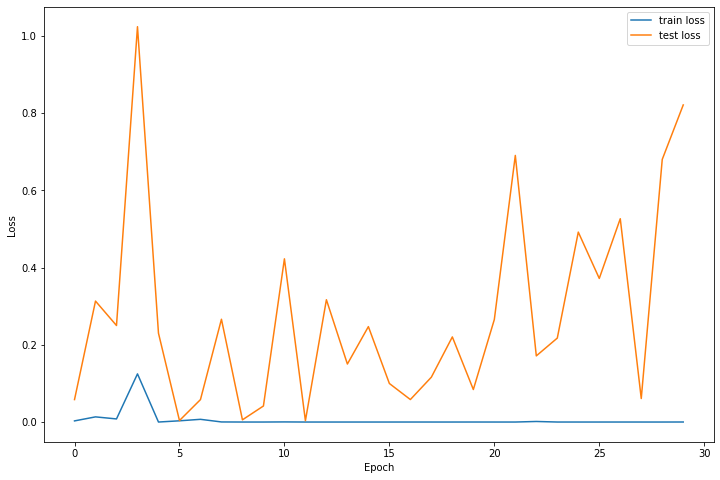

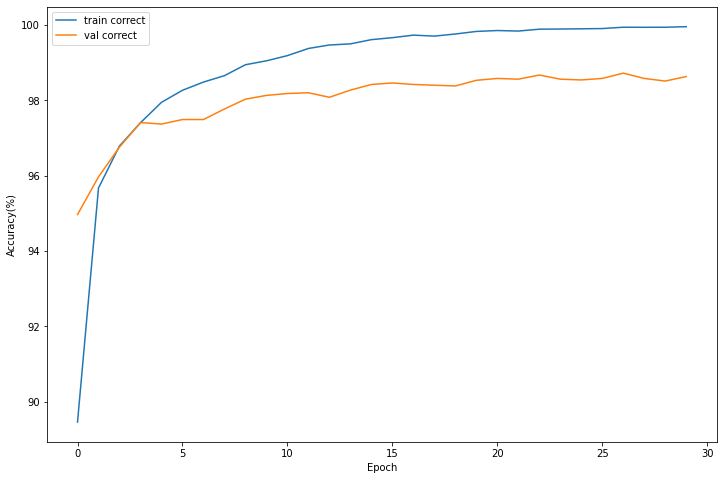

In [29]:
#  Plot train loss and val loss 
plt.figure(figsize=(12,8))
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(losses['train'],label = 'train loss')
plt.plot(losses['val'],label  = 'test loss')
plt.legend()

#  Plot train and val accuracy
plt.figure(figsize=(12,8))
plt.xlabel("Epoch")
plt.ylabel("Accuracy(%)")
plt.plot(corrects['train'],label = 'train correct')
plt.plot(corrects['val'], label = 'val correct')
plt.legend()

In [30]:
print('train: ',max(corrects['train']))
print('val: ',max(corrects['val']))

train:  99.952
val:  98.71871871871872


## 5. Check Accuracy on Testset

In [31]:
correct = 0
total = 0

with torch.no_grad():
    for data in testset:
        X,y = data
        if use_gpu:
          X = Variable(X).cuda()
          y = Variable(y).cuda()
        output = net(X.view(-1,784))
        for idx, i in enumerate(output):
            if torch.argmax(i) == y[idx]:
                correct += 1
            total += 1
print("Accuracy: ", round(correct/total, 4))

Accuracy:  0.9868


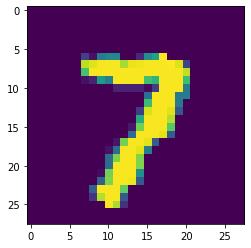

In [32]:
plt.imshow(X[0].cpu().view(28,28))
plt.show()

In [33]:
print(torch.argmax(net(X[0].view(-1,784))[0]))

tensor(7, device='cuda:0')
